In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt

In [96]:
#导入数据并标记空值
def load_data():
    return pd.read_csv(filepath_or_buffer = "./train.csv",
                       na_values = ['','_______','_','NA','!@9#%8','#F%$D@*&8','NM','__10000__'],
                       low_memory = False,
                       nrows= 100000
                       )
origen_df = load_data()
copy_df = origen_df.copy()
string_columns = ['Name','SSN','Occupation','Type_of_Loan','Credit_Mix','Credit_History_Age','Payment_of_Min_Amount','Payment_Behaviour']
number_columns = ['Age','Annual_Income','Monthly_Inhand_Salary','Num_Bank_Accounts','Num_Credit_Card',
                            'Interest_Rate','Num_of_Loan','Delay_from_due_date','Num_of_Delayed_Payment','Changed_Credit_Limit',
                            'Num_Credit_Inquiries','Outstanding_Debt','Credit_Utilization_Ratio','Total_EMI_per_month','Amount_invested_monthly',
                            'Monthly_Balance']

In [97]:
#将数字类型中的字符串标记为空值
def mark_strings_as_nan(df, columns):
    for column in columns:
        df[column] = pd.to_numeric(df[column], errors='coerce')

In [98]:
#将负数标记为空值
def mark_negatives_as_nan(df, columns):
        for column in columns:
            if(column != 'Delay_from_due_date' and column != 'Changed_Credit_Limit'):
                df[column] = np.where(df[column] < 0, np.nan, df[column])

In [99]:
#将超出有效范围的数字标记为空值
def mark_outliers_as_nan(df, columns):
    for column in columns:
        if(column != 'Amount_invested_monthly' and column != 'Delay_from_due_date' and column != 'Changed_Credit_Limit' and column != 'Credit_Utilization_Ratio'
           and column != 'Monthly_Balance'):
            median = df[column].median()
            mad = np.median(np.abs(df[column] - median))
            
            lower_limit = median - (3 * mad)
            upper_limit = median + (3 * mad)
            
            df[column] = np.where((df[column] < lower_limit) | (df[column] > upper_limit), np.nan, df[column])
    df['Age'] = np.where(df['Age'] > 94, np.nan, df['Age'])

In [100]:
# 将字符串类型的空值设为出现次数最多的值，对于特定列取平均值
def fill_most_frequent(df, columns):
    for column in columns:
        if column == 'Num_of_Delayed_Payment' or column == 'Changed_Credit_Limit' or column == 'Amount_invested_monthly':
            # 对于 'Num_of_Delayed_Payment' 和 'Changed_Credit_Limit'，取平均值
            df[column].fillna(df[column].mean(), inplace=True)
        else:
            # 对于其他列，取出现次数最多的值
            mode_values = df[column].mode()
            if not mode_values.empty:
                mode_value = mode_values.iloc[0]
                df[column].fillna(mode_value, inplace=True)


In [101]:
#创建转化器，将信用评级转化为数字
class Transformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass


    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()

        customer_ID_data = []
        c_id = X_transformed['Customer_ID']
        for c in c_id:
            extracted_value = c.split('_')[1]
            decimal_value = int(extracted_value, 36)
            customer_ID_data.append(decimal_value)
        
        X_transformed['Month'] = X_transformed['Month'].map({'January': 1, 'February': 2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8})
        X_transformed['Occupation'] = X_transformed['Occupation'].map({'Accountant': 1, 'Architect': 2,'Developer':3,'Doctor':4,'Engineer':5,'Entrepreneur':6,'Journalist':7,'Lawyer':8,
                                                                       'Manager':9,'Mechanic':10,'Media_Manager':11,'Musician':12,'Scientist':13,'Teacher':14,'Writer':15})

        X_transformed['Customer_ID'] = pd.Series(customer_ID_data)
        X_transformed['Credit_Mix'] = X_transformed['Credit_Mix'].map({'Good': 3, 'Standard': 2, 'Bad': 1})
        X_transformed['Credit_Score'] = X_transformed['Credit_Score'].map({'Good': 3, 'Standard': 2, 'Poor': 1})
        X_transformed['Payment_of_Min_Amount'] = X_transformed['Payment_of_Min_Amount'].map({'Yes': 1, 'No': 0})
        X_transformed['Payment_Behaviour'] = X_transformed['Payment_Behaviour'].map({
            'Low_spent_Small_value_payments': 1, 'Low_spent_Medium_value_payments': 2, 'Low_spent_Large_value_payments' : 3,
            'High_spent_Small_value_payments': 2, 'High_spent_Medium_value_payments': 4, 'High_spent_Large_value_payments' : 6
            })
        
        X_transformed['Credit_History_Age'] = X_transformed['Credit_History_Age'].str.extract(r'(\d+) Years',expand = False).astype(int)

        Auto_data = []
        Credit_Builder_data = []
        Personal_data = []
        Home_Equity_data = []
        Not_Specified_data = []
        Mortgage_data = []
        Student_data = []
        Debt_Consolidation_data = []
        Payday_data = []
        l_tp = X_transformed['Type_of_Loan']
        for l in l_tp:
            if pd.isnull(l):
                Auto_data.append(0)
                Credit_Builder_data.append(0)
                Personal_data.append(0)
                Home_Equity_data.append(0)
                Not_Specified_data.append(0)
                Mortgage_data.append(0)
                Student_data.append(0)
                Debt_Consolidation_data.append(0)
                Payday_data.append(0)
            else:
                Auto_data.append(l.count('Auto'))
                Credit_Builder_data.append(l.count('Credit-Builder'))
                Personal_data.append(l.count('Personal'))
                Home_Equity_data.append(l.count('Home Equity'))
                Not_Specified_data.append(l.count('Not Specified'))
                Mortgage_data.append(l.count('Mortgage'))
                Student_data.append(l.count('Student'))
                Debt_Consolidation_data.append(l.count('Debt Consolidation'))
                Payday_data.append(l.count('Payday'))
        X_transformed['Auto Loan'] = pd.Series(Auto_data)
        X_transformed['Credit-Builder Loan'] = pd.Series(Credit_Builder_data)
        X_transformed['Personal Loan'] = pd.Series(Personal_data)
        X_transformed['Home Equity Loan'] = pd.Series(Home_Equity_data)
        X_transformed['Not Specified Loan'] = pd.Series(Not_Specified_data)
        X_transformed['Mortgage Loan'] = pd.Series(Mortgage_data)
        X_transformed['Student Loan'] = pd.Series(Student_data)
        X_transformed['Debt Consolidation Loan'] = pd.Series(Debt_Consolidation_data)
        X_transformed['Payday Loan'] = pd.Series(Payday_data)

        copy_credit_score = X_transformed['Credit_Score']
        del_columns = ['ID','Name','SSN','Type_of_Loan','Credit_Score']
        X_transformed = X_transformed.drop(del_columns,axis=1)
        X_transformed['Credit_Score'] = copy_credit_score
        return X_transformed

In [102]:
#将异常值设为出现次数最多的值
list_of_dfs = [copy_df.iloc[i:i+8] for i in range(0, len(copy_df), 8)]
for df in list_of_dfs:
    mark_strings_as_nan(df,number_columns)
    mark_negatives_as_nan(df,number_columns)
    mark_outliers_as_nan(df,number_columns)
    fill_most_frequent(df,number_columns + string_columns)
new_df = pd.concat(list_of_dfs, ignore_index=True)


Text(0.5, 1.0, 'Credit_Score')

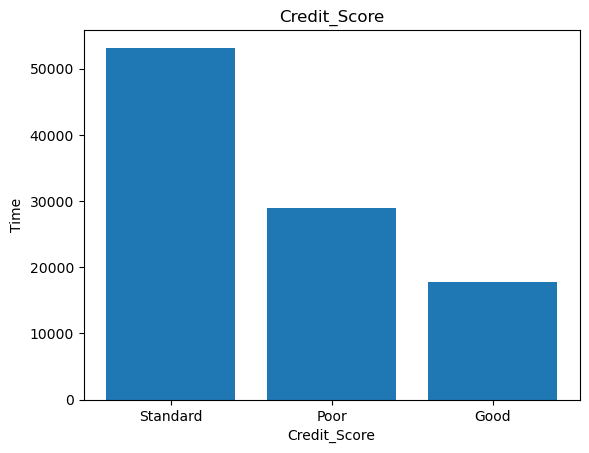

In [103]:
#数据可视化
value_counts = new_df['Credit_Score'].value_counts()
plt.bar(value_counts.index, value_counts.values)
plt.xlabel('Credit_Score')
plt.ylabel('Time')
plt.title('Credit_Score')

In [104]:
#调用转化器
transformer = Transformer()
new_df = transformer.transform(new_df)

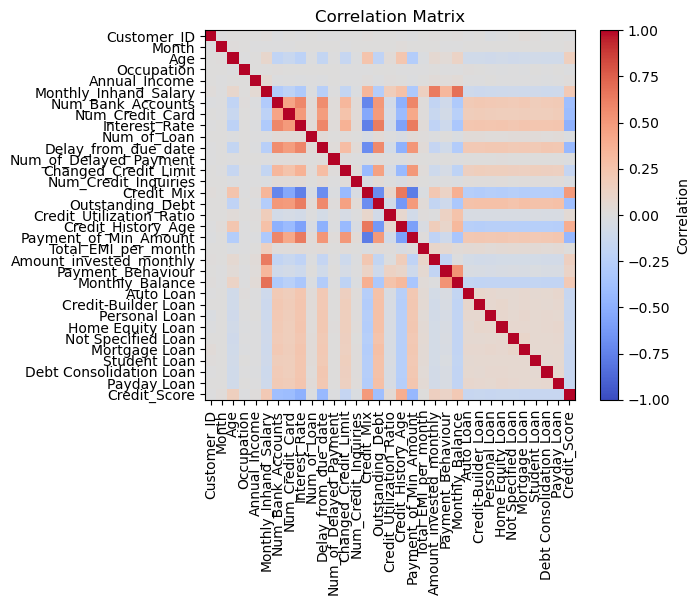

In [105]:
#绘制关系图
corr_matrix = new_df.corr()
plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.title('Correlation Matrix')
plt.xticks(ticks=range(corr_matrix.shape[0]), labels=corr_matrix.columns,rotation=90)
plt.yticks(ticks=range(corr_matrix.shape[1]), labels=corr_matrix.columns)
plt.show()

In [106]:
#选择需要的属性并存储新文件
# new_df.to_csv('output.csv',index=False)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

new_df = pd.read_csv('output.csv')

features = ['Age', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Delay_from_due_date', 'Credit_Mix', 'Credit_History_Age', 'Payment_of_Min_Amount']
X = new_df[features]
y = new_df['Credit_Score']

# 使用 StratifiedShuffleSplit 进行分层抽样
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in stratified_split.split(X, y):
    X_train_stratified, X_test_stratified = X.iloc[train_index], X.iloc[test_index]
    y_train_stratified, y_test_stratified = y.iloc[train_index], y.iloc[test_index]

# 输出分层抽样前的训练集和测试集的形状
print("Before Stratified Sampling:")
print("X_train shape:", X_train_stratified.shape)
print("X_test shape:", X_test_stratified.shape)
print("y_train shape:", y_train_stratified.shape)
print("y_test shape:", y_test_stratified.shape)

# Basic Model Before Stratified Sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
knn_basic = KNeighborsClassifier(n_neighbors=2)
knn_basic.fit(X_train, y_train)

y_pred_basic = knn_basic.predict(X_test)

accuracy_basic = accuracy_score(y_test, y_pred_basic)
print(f"Basic Model Accuracy (Before Stratified Sampling): {accuracy_basic}")

# Basic Model After Stratified Sampling
knn_after_stratified = KNeighborsClassifier(n_neighbors=2)
knn_after_stratified.fit(X_train_stratified, y_train_stratified)

y_pred_after_stratified = knn_after_stratified.predict(X_test_stratified)

accuracy_after_stratified = accuracy_score(y_test_stratified, y_pred_after_stratified)
print(f"Basic Model Accuracy (After Stratified Sampling): {accuracy_after_stratified}")


# Balanced Model
knn_balanced = KNeighborsClassifier(n_neighbors=2)
knn_balanced.fit(X_train, y_train)

y_pred_balanced = knn_balanced.predict(X_test)

accuracy_balanced = accuracy_score(y_test, y_pred_balanced)
print(f"Balanced Model Accuracy: {accuracy_balanced}")

# Oversampled + SMOTE Model
smote = SMOTE(random_state=42)
knn_smote = KNeighborsClassifier(n_neighbors=2)
pipeline_smote = Pipeline([('smote', smote), ('knn', knn_smote)])
pipeline_smote.fit(X_train, y_train)

y_pred_smote = pipeline_smote.predict(X_test)

accuracy_smote = accuracy_score(y_test, y_pred_smote)
print(f"Oversampled + SMOTE Model Accuracy: {accuracy_smote}")

# Class Model (Random Forest)
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Class Model (Random Forest) Accuracy: {accuracy_rf}")




Before Stratified Sampling:
X_train shape: (80000, 9)
X_test shape: (20000, 9)
y_train shape: (80000,)
y_test shape: (20000,)
Basic Model Accuracy (Before Stratified Sampling): 0.77725
Basic Model Accuracy (After Stratified Sampling): 0.7822
Balanced Model Accuracy: 0.77725
Oversampled + SMOTE Model Accuracy: 0.7815
Class Model (Random Forest) Accuracy: 0.7911


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

# import the csv file into a dataframe object
new_df = pd.read_csv("output.csv")

In [5]:
# Stratify Sampling

# Stratify the dataset by attribute "Num_of_Delayed_Payment"
# There are six stratums, and each stratum has a size of 4
new_df["Num_of_Delayed_Payment_Cat"] = \
    pd.cut(new_df["Num_of_Delayed_Payment"],
           bins = [-np.inf, 4, 8, 12, 16, 20, np.inf], 
           labels = [1, 2, 3, 4, 5, 6])

# Returns stratified randomized folds
# The folds preserve the percentage of samples for each class
# the test dataset is 20%, and the train dataset is 80%
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Based on each train index and test index,
# locate the data records in the original dataframe,
# and copy the data records to its corresponding variables
for train_index, test_index in split.split(new_df,
    new_df["Num_of_Delayed_Payment_Cat"]):
    strat_train_set = new_df.loc[train_index]
    strat_test_set = new_df.loc[test_index]

In [6]:
# Select the feature columns
feature_cols = ['Customer_ID','Age','Annual_Income','Monthly_Inhand_Salary','Num_Bank_Accounts','Num_Credit_Card',	
             'Interest_Rate','Num_of_Loan','Delay_from_due_date','Num_of_Delayed_Payment','Changed_Credit_Limit','Num_Credit_Inquiries',	
            'Credit_Mix','Outstanding_Debt','Credit_Utilization_Ratio','Credit_History_Age','Payment_of_Min_Amount','Total_EMI_per_month','Amount_invested_monthly','Payment_Behaviour','Monthly_Balance','Auto Loan',
            'Credit-Builder Loan','Personal Loan','Home Equity Loan','Not Specified Loan','Mortgage Loan','Student Loan','Debt Consolidation Loan','Payday Loan']

# Split train dataset into features and target variable
X_train = strat_train_set[feature_cols] # Features
y_train = strat_train_set.Credit_Score # Target variable

# Split test dataset into features and target variable
X_test = strat_test_set[feature_cols] # Features
y_test = strat_test_set.Credit_Score # Target variable

In [7]:
# Decision Tree

# Create Decision Tree classifier object
dtc = DecisionTreeClassifier()

# Train Decision Tree Classifier
dtc = dtc.fit(X_train, y_train)

# Predict the class for the test dataset
y_test_prediction = dtc.predict(X_test)

In [8]:
# Evaluate the model
print("Accuracy: ", metrics.accuracy_score(y_test, y_test_prediction))

Accuracy:  0.72995


In [9]:
# fine-tuning the model

# hyperparameter grid
parameter_grid = {
    "criterion" : ["gini", "entropy", "log_loss"],
    "max_depth" : [10, 20, 30, None], 
    "min_samples_split" : [2, 5, 10], 
    "min_samples_leaf" : [1, 2, 4]
}

In [8]:
# Instantiate decision tree classifier for fine-tuning the model
dtc_tuning = DecisionTreeClassifier()

# Instantiate GridSearchCV object
grid_search = GridSearchCV(dtc_tuning, parameter_grid, cv = 5, scoring = "accuracy")

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [10, 20, 30, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [9]:
# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)

# Get the best model
best_dtc = grid_search.best_estimator_

#Make predictions on the best data using the best model
y_test_prediction_best = best_dtc.predict(X_test)

# Evaluate the model with the best hyperparameters
print("Accuracy with best hyperparameters: ", metrics.accuracy_score(y_test, y_test_prediction_best))

Best hyperparameters:  {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 5}
Accuracy with best hyperparameters:  0.7415


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import sklearn.naive_bayes as nb

# Load the dataset
new_df = pd.read_csv("output.csv")

# Extract features (all columns except 'Credit_Score')
features = new_df.drop(columns=['Credit_Score'])

# Extract the target column ('Credit_Score')
target = new_df['Credit_Score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

# Raw Model
raw_naive_bayes_classifier = nb.GaussianNB()

# Train the raw classifier
raw_naive_bayes_classifier.fit(X_train, y_train)

# Make predictions on the testing set for the raw model
y_pred_raw = raw_naive_bayes_classifier.predict(X_test)

# Evaluate the accuracy of the raw model
accuracy_raw = accuracy_score(y_test, y_pred_raw)
print(f"Raw Model Accuracy: {accuracy_raw:.2f}")

# Default Model (without hyperparameter tuning)
default_naive_bayes_classifier = nb.GaussianNB()

# Train the default classifier
default_naive_bayes_classifier.fit(X_train, y_train)

# Make predictions on the testing set for the default model
y_pred_default = default_naive_bayes_classifier.predict(X_test)

# Evaluate the accuracy of the default model
accuracy_default = accuracy_score(y_test, y_pred_default)
print(f"Default Model Accuracy: {accuracy_default:.2f}")

# Fine-Tuned Model
# Create a Gaussian Naive Bayes classifier
fine_tuned_naive_bayes_classifier = nb.GaussianNB()

# Define the parameter grid to search
param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(fine_tuned_naive_bayes_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the fine-tuned classifier with the best hyperparameters
fine_tuned_naive_bayes_classifier = nb.GaussianNB(var_smoothing=best_params['var_smoothing'])
fine_tuned_naive_bayes_classifier.fit(X_train, y_train)

# Make predictions on the testing set for the fine-tuned model
y_pred_fine_tuned = fine_tuned_naive_bayes_classifier.predict(X_test)

# Evaluate the accuracy of the fine-tuned model
accuracy_fine_tuned = accuracy_score(y_test, y_pred_fine_tuned)
print(f"Fine-Tuned Model Accuracy: {accuracy_fine_tuned:.2f}")

# Display the classification report for the fine-tuned model
print("Classification Report (Fine-Tuned Model):")
print(classification_report(y_test, y_pred_fine_tuned))


Raw Model Accuracy: 0.53
Default Model Accuracy: 0.53
Best Hyperparameters: {'var_smoothing': 1e-08}
Fine-Tuned Model Accuracy: 0.54
Classification Report (Fine-Tuned Model):
              precision    recall  f1-score   support

           1       0.53      0.29      0.38      5789
           2       0.55      0.82      0.66     10674
           3       0.37      0.12      0.18      3537

    accuracy                           0.54     20000
   macro avg       0.49      0.41      0.40     20000
weighted avg       0.52      0.54      0.49     20000

